## Connect MySQL

In [24]:
import json
import mysql.connector
import getpass

with open('config.json') as f:
    config = json.load(f)

host_name = config['host']
user_name = config['user']
passwd = getpass.getpass(prompt='Enter your password: ')

## Dump data from csv to DB

In [25]:
import pandas as pd

cnx = mysql.connector.connect(user=user_name, password=passwd, host=host_name)

cursor = cnx.cursor()
cursor.execute("DROP DATABASE IF EXISTS DB_wine")
cursor.execute("CREATE DATABASE IF NOT EXISTS DB_wine")
cursor.execute("USE DB_wine")

# Define the table name and columns
table_name = 'wine'
header = ['Class', 'Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']
columns = ', '.join([f"`{column}` VARCHAR(255)" for column in header])

# Create the table
create_table_query = f"CREATE TABLE `{table_name}` ({columns}) ENGINE=InnoDB"
cursor.execute(create_table_query)

csv_path = config['csv_path']
df = pd.read_csv(csv_path)

# Insert the data into the table
for _, row in df.iterrows():
    values = ", ".join([f"'{str(value)}'" for value in row])
    insert_query = f"INSERT INTO `{table_name}` VALUES ({values})"
    cursor.execute(insert_query)

# Commit the changes and close the connection
cnx.commit()


## Select data into DataFrame

In [26]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Execute a SELECT query to fetch data from the table
select_query = f"SELECT * FROM wine"
cursor.execute(select_query)

# Fetch all the rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [column[0] for column in cursor.description]

# Convert the fetched data into a pandas DataFrame
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
cnx.close()

# Print the DataFrame
print(df)

   Class Alcohol Malicacid   Ash Alcalinity_of_ash Magnesium Total_phenols   
0    1.0    13.2      1.78  2.14              11.2     100.0          2.65  \
1    1.0   13.16      2.36  2.67              18.6     101.0           2.8   
2    1.0   14.37      1.95   2.5              16.8     113.0          3.85   
3    1.0   13.24      2.59  2.87              21.0     118.0           2.8   
4    1.0    14.2      1.76  2.45              15.2     112.0          3.27   
5    1.0   14.39      1.87  2.45              14.6      96.0           2.5   
6    1.0   14.06      2.15  2.61              17.6     121.0           2.6   
7    1.0   14.83      1.64  2.17              14.0      97.0           2.8   
8    1.0   13.86      1.35  2.27              16.0      98.0          2.98   
9    2.0   12.37      0.94  1.36              10.6      88.0          1.98   
10   2.0   12.33       1.1  2.28              16.0     101.0          2.05   
11   2.0   12.64      1.36  2.02              16.8     100.0    

## Run PCA

In [27]:
# PCA analysis
pca = PCA(n_components=3)  # specify dimensions for PCA
class_var = df['Class']
features = df.drop('Class', axis=1)  # Exclude the target variable 'Class' from the trait
pca_result = pca.fit_transform(features)

# Convert categorical variables to numerical representations
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(class_var)

# explained variance ratio: the percentage of variance that is attributed by each of the selected components
explained_variance_ratio = pca.explained_variance_ratio_
print('Explained Variance Ratio:', explained_variance_ratio)

# cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print('Cumulative Explained Variance Ratio:', cumulative_explained_variance_ratio)

Explained Variance Ratio: [9.98835290e-01 1.03407584e-03 9.70412787e-05]
Cumulative Explained Variance Ratio: [0.99883529 0.99986937 0.99996641]


## Plot Scatter Matrix

          PC1        PC2       PC3  Target
0  286.555925  -4.150552  5.299580       0
1  421.527756  -4.495781 -2.655050       0
2  716.688440   2.825980 -1.560060       0
3  -28.163110  19.387835 -0.882240       0
4  686.679113   2.165437  0.194232       0


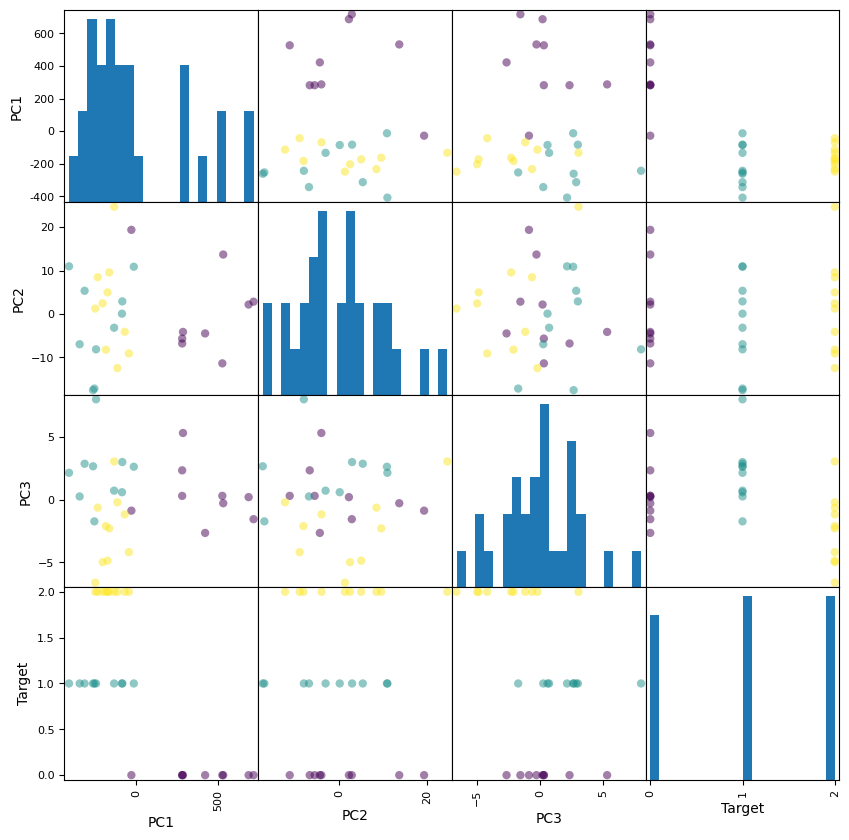

In [28]:
# Create DataFrame with principal components
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
df_pca['Class'] = class_encoded
print(df_pca.head())

# Plot visualization charts using scatter matrix
pd.plotting.scatter_matrix(df_pca, c=df_pca['Class'], figsize=(10, 10), marker='o', hist_kwds={'bins': 20})
plt.show()